## Regression Project

Build a linear regression model that predicts the `price` column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

1. Data Cleaning has already been performed on this data
2. Explore the data, keeping an eye on useful features and potential issues 
3. Choose a model validation scheme (simple or cross validation)
4. Fit a Linear Regression Model
5. Evaluate your model - check assumptions, metrics, and coefficient estimates
6. Engineer Features as needed
7. Repeat Steps 2, 4, 5, 6 as needed
8. Once you are ready, fit your final model and report final model performance estimate by scoring on the test data. Report both test R-squared and MAE.

A reasonable goal is to get a validation MAE of <= 500 dollars.


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

rentals_df = pd.read_csv("./Data/sf_clean.csv") 
rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [110]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


## EDA


In [111]:
# hood_district appears as numeric but is in fact catagorial
# Could change type to object, string, catagory

rentals_df["hood_district"] = rentals_df["hood_district"].astype("object")

In [112]:
# Summary Statistics
# Emphasis on Median (50%) rent price
# Analyzing the large difference from 75% percentile to max indicates probability of outliers

rentals_df.describe()

,price,sqft,beds,bath
count,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293
std,1546.222670,474.629798,1.076710,0.562714
min,750.000000,150.000000,0.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000
50%,3300.000000,900.000000,2.000000,1.000000
75%,4242.000000,1200.000000,2.000000,2.000000
max,19000.000000,3500.000000,6.000000,4.000000


<Axes: xlabel='price', ylabel='Count'>

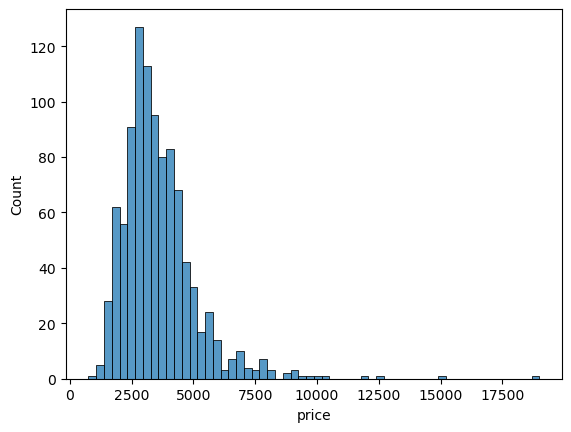

In [113]:
sns.histplot(rentals_df, x="price")

# Confirms outliers regarding price
# Indicates most apartments cost between 1500-6000
# A small cluster is observed around 6500-8000

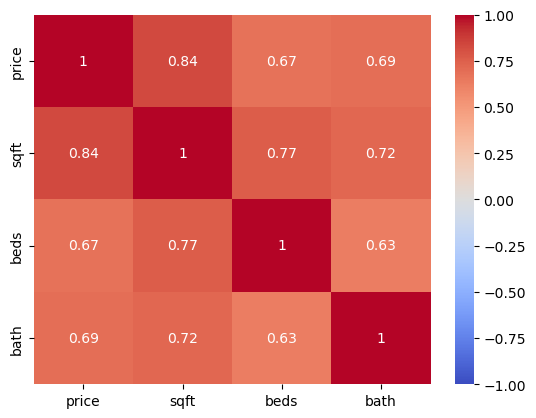

In [114]:
sns.heatmap(
    rentals_df.corr(numeric_only=True),
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True
);

# All red indicates positive correlation within our data
# SQFT strongest feature
# SQFT/ Beds / Bath correlated with each other - Logical
# Possible collinearity issues due to heavily correlated features

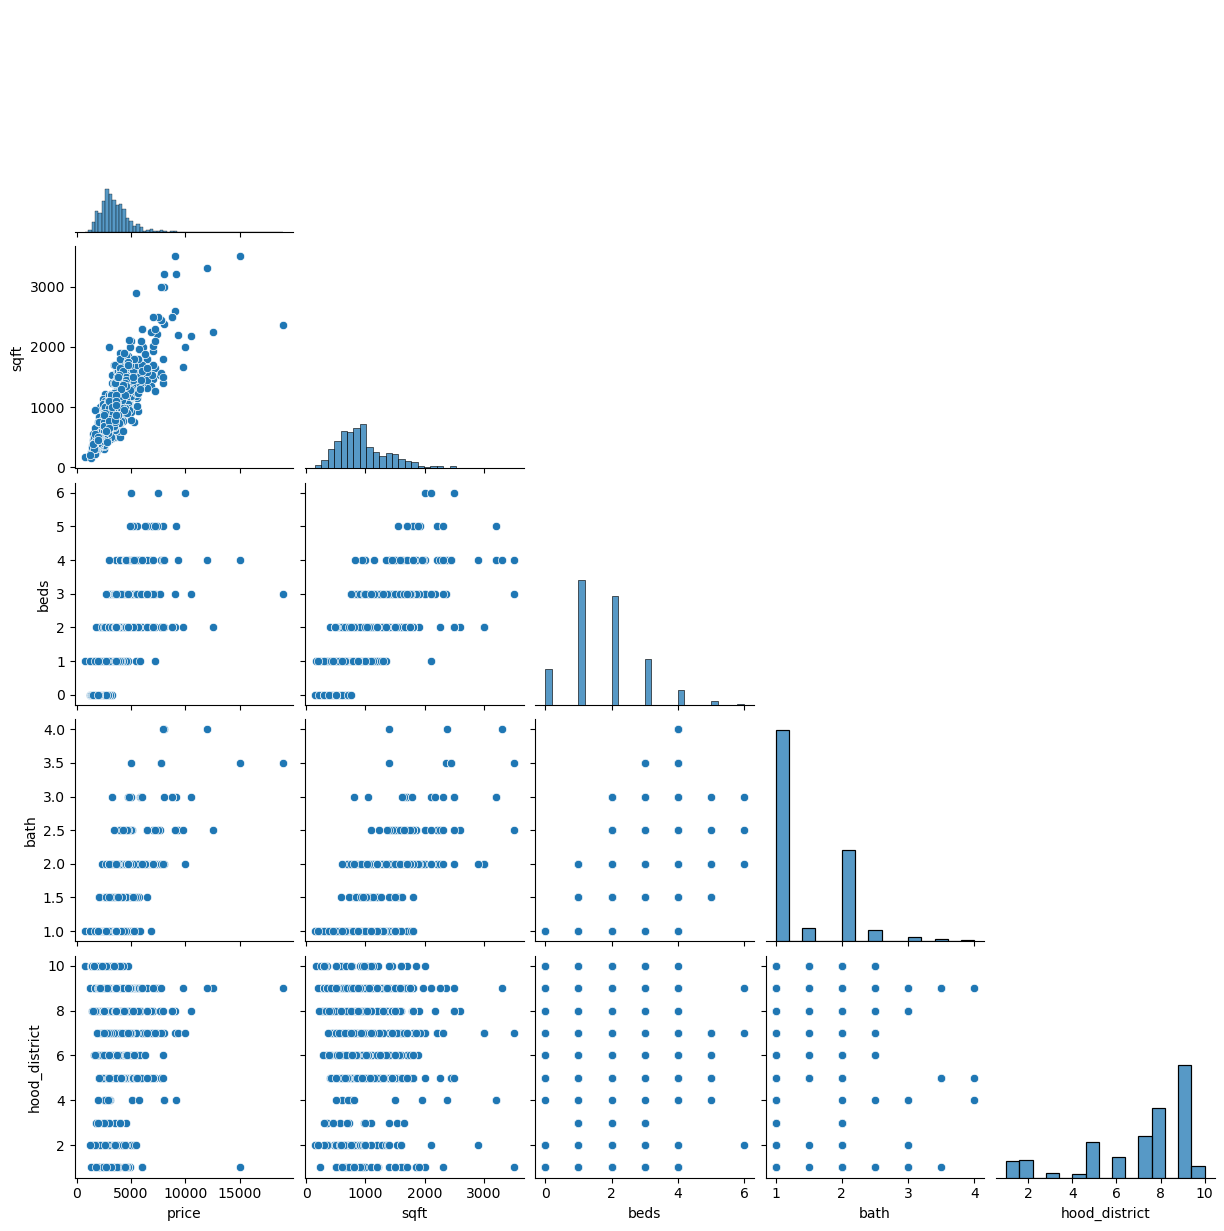

In [115]:
sns.pairplot(rentals_df, corner=True)

# Significant relationship between sqft & price - linear pattern through bulk
# Beds & Baths show linearity 
# hood_district was detected as numerical - prices higher at 6,7,8

In [116]:
# Explore value counts for our catagorical features

# Write function to count values in each object feature
# Create empty DataFrame to store the value counts
# Iterate through columns with data type "object"
def value_counter(df):
    value_series = pd.DataFrame()
    for col in df.select_dtypes(["object"]).columns:
        print(df[col].value_counts())
        
value_counter(rentals_df)

# Goal is to identify catagories with small representation
# Bin together similar catagories

(a) in-unit       488
(b) on-site       370
(c) no laundry    131
Name: laundry, dtype: int64
(d) no pets    510
(a) both       367
(c) cats        91
(b) dogs        21
Name: pets, dtype: int64
(c) multi     937
(a) single     40
(b) double     12
Name: housing_type, dtype: int64
(d) no parking    478
(b) protected     439
(c) off-street     38
(a) valet          34
Name: parking, dtype: int64
9.0     332
8.0     207
7.0     123
5.0     106
6.0      62
2.0      51
1.0      50
10.0     33
3.0      14
4.0      11
Name: hood_district, dtype: int64


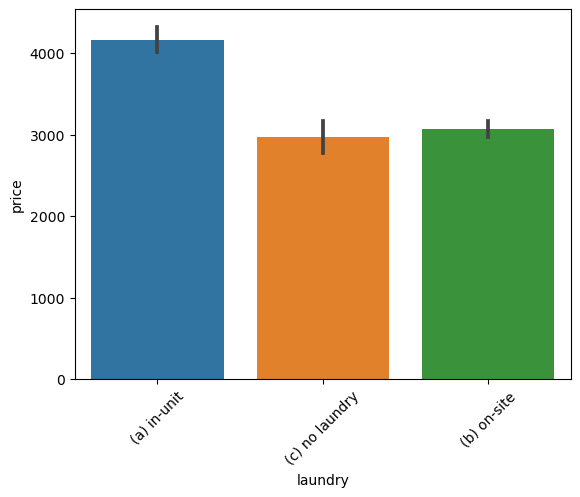

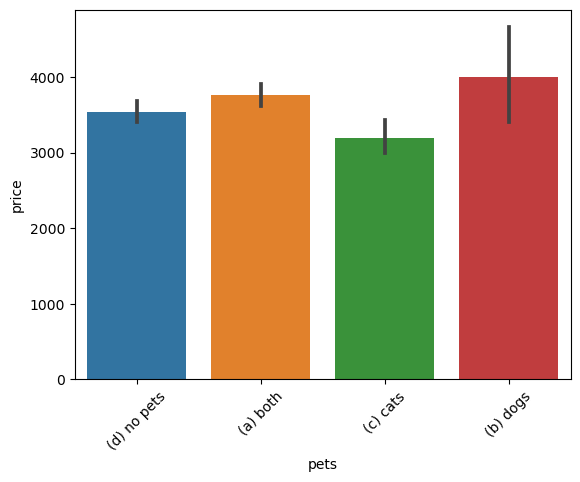

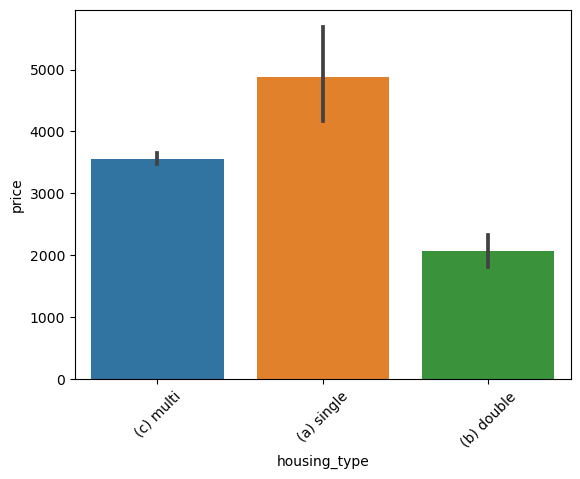

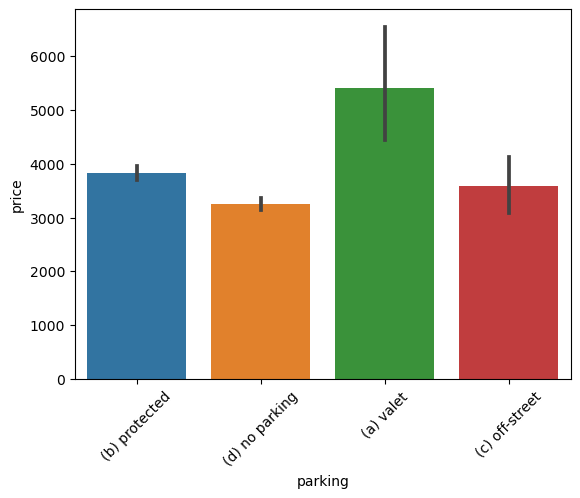

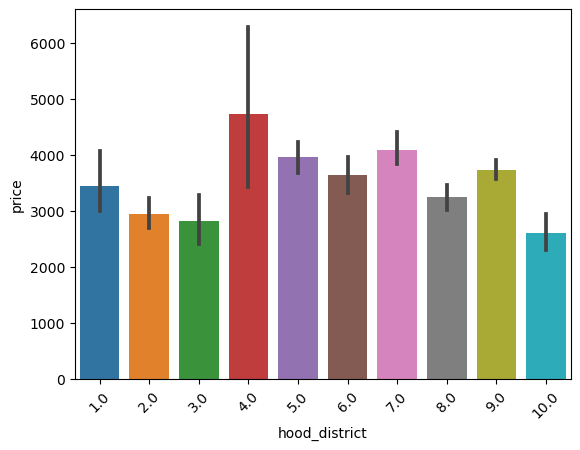

In [117]:
def bar_plotter(df, target):
    for col in df.select_dtypes(["object"]).columns:
            sns.barplot(data=df, x=col, y=target)
            plt.xticks(rotation=45)
            plt.show()
            
bar_plotter(rentals_df, "price")

# Goal is to observe similar features with low observation counts that could possibly be binned together

## Feature Engineering

#### Identify and Group Catagories together / Try a quadratic relationship (squared variable) for highly correlated features

In [118]:
# Group Catagories Together

# Laundry "in-unit" or "not-in-unit"
# Mean price of not-in-unit similar
laundry_1 = {
    "(a) in-unit":"in-unit",
    "(b) on-site":"not-in-unit",
    "(c) no laundry":"not-in-unit"
}

# allow_dogs or no_dogs
pet_1 = {
    "(a) both": "allow_dogs",
    "(b) dogs":"allow_dogs",
    "(c) cats":"no_dogs",
    "(d) no pets":"no_dogs"
}

# "single" or "multi"
# Low observations of doubles and conceptually closer to multi
housing_type_1 = {
    "(a) single":"single",
    "(b) double":"multi",
    "(c) mutli": "multi"
}

# Goal is to get "hood_districts" regional
# Lower observations in specific districts are now higher due to created bins
district_1 = {
    1.0:"west",
    2.0:"southwest",
    3.0:"southwest",
    4.0:"central",
    5.0:"central",
    6.0:"central",
    7.0:"marina",
    8.0:"north beach",
    9.0:"FiDi/SOMA",
    10.0:"southwest"
}

In [119]:
# Goal is to avoid overfitting so we want to map our catagories created above
eng_df = rentals_df.assign(
    hood_district = rentals_df["hood_district"].map(district_1),
    housing_type = rentals_df["housing_type"].map(housing_type_1),
    pets = rentals_df["pets"].map(pet_1),
    laundry = rentals_df["laundry"].map(laundry_1),
#         sqft2
#         sqft3
#         beds2
#         beds3
#         bath2
#         bath3
        beds_bath_ratio = rentals_df["beds"] / rentals_df["bath"]    
)

eng_df = pd.get_dummies(eng_df, drop_first=True)

In [120]:
eng_df.head()

,price,sqft,beds,bath,beds_bath_ratio,laundry_not-in-unit,pets_no_dogs,housing_type_single,parking_(b) protected,parking_(c) off-street,parking_(d) no parking,hood_district_central,hood_district_marina,hood_district_north beach,hood_district_southwest,hood_district_west
0,6800,1600.0,2.0,2.0,1.0,0,1,0,1,0,0,0,1,0,0,0
1,3500,550.0,1.0,1.0,1.0,0,0,0,1,0,0,0,1,0,0,0
2,5100,1300.0,2.0,1.0,2.0,0,0,0,0,0,1,0,1,0,0,0
3,9000,3500.0,3.0,2.5,1.2,0,1,0,1,0,0,0,1,0,0,0
4,3100,561.0,1.0,1.0,1.0,1,0,0,0,0,1,0,1,0,0,0


## Data Splitting / Model Fitting & Validation Scoring

In [121]:
# Model 1 - Fit on untrasformed data first
# Model 2 - Next test - drop pets and housing
# Model 3 - Log Transform 
# Model 4 - bed_bath_ratio

from sklearn.model_selection import train_test_split

target = "price"

drop_cols = [
    "pets_no_dogs",
    "housing_type_single",
#     "beds_bath_ratio"
]

X = sm.add_constant(eng_df.drop([target] + drop_cols, axis=1))

# Log Transform to test normality
y = np.log(eng_df[target])
# y = eng_df[target]

# test split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=41)

In [122]:
def cross_val(X, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=41)
    # Create list for each fold
    
    cv_lm_tr_r2s = []
    cv_lm_tr_mae = []
    cv_lm_val_r2s = []
    cv_lm_val_mae = []
    
    for train_ind, val_ind in kf.split(X, y):
        # Subset data based on CV folds
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        # Fit the Model on fold's training data
        model = sm.OLS(y_train, X_train).fit()
        # Append Validation score to list 
        cv_lm_tr_r2s.append(r2(y_train, model.predict(X_train)))
        cv_lm_tr_mae.append(mae(y_train, model.predict(X_train)))
        cv_lm_val_r2s.append(r2(y_val, model.predict(X_val),))
        cv_lm_val_mae.append(mae(y_val, model.predict(X_val),))
        
        
    print(f"All Training R2s: {[round(x, 3) for x in cv_lm_tr_r2s]}")
    print(f"Training R2s: {round(np.mean(cv_lm_tr_r2s), 3)} +- {round(np.std(cv_lm_tr_r2s), 3)}")
    
    print(f"Training MAEs: {[round(x, 3) for x in cv_lm_tr_mae]}")
    print(f"Training MAEs: {round(np.mean(cv_lm_tr_mae), 3)} +- {round(np.std(cv_lm_tr_mae), 3)}")    
        
    print(f"All Validation R2s: {[round(x, 3) for x in cv_lm_val_r2s]}")
    print(f"Cross Val R2s: {round(np.mean(cv_lm_val_r2s), 3)} +- {round(np.std(cv_lm_val_r2s), 3)}")

    print(f"All Validation MAEs: {[round(x, 3) for x in cv_lm_val_mae]}")
    print(f"Cross Val MAEs: {round(np.mean(cv_lm_val_mae), 3)} +- {round(np.std(cv_lm_val_mae), 3)}")
    
    return model
    
model = cross_val(X, y, 5)
    

All Training R2s: [0.806, 0.803, 0.808, 0.809, 0.797]
Training R2s: 0.804 +- 0.004
Training MAEs: [0.13, 0.127, 0.129, 0.131, 0.131]
Training MAEs: 0.13 +- 0.001
All Validation R2s: [0.789, 0.797, 0.779, 0.769, 0.819]
Cross Val R2s: 0.791 +- 0.017
All Validation MAEs: [0.131, 0.14, 0.137, 0.127, 0.129]
Cross Val MAEs: 0.133 +- 0.005


In [123]:
# get p-values: 
model.summary()

# Removing pets and housing_type features due to insignificance

# Model 4 - Interpretation we would remove beds due to - coeff / prediction we would keep model due to improvement

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     187.0
Date:                Tue, 05 Sep 2023   Prob (F-statistic):          2.26e-204
Time:                        21:35:29   Log-Likelihood:                 246.94
No. Observations:                 633   AIC:                            -465.9
Df Residuals:                     619   BIC:                            -403.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.5193      0.062    122.036      0.000       7.398       7.640
sqft                          0.0004   2.52e-05     14.356      0.000       0.000       0.000
beds                         -0.0491      0.027     -1.825      0.068      -0.102       0.004
bath                          0.2207      0.036      6.115      0.000       0.150       0.292
beds_bath_ratio               0.1961      0.032      6.142      0.000       0.133       0.259
laundry_not-in-unit          -0.0916      0.016     -5.882      0.000      -0.122      -0.061
parking_(b) protected        -0.1361      0.041     -3.328      0.001      -0.216      -0.056
parking_(c) off-street       -0.1066      0.053     -2.014      0.044      -0.210      -0.003
parking_(d) no parking       -0.2151      0.042     -5.110      0.000      -0.298      -0.132
hood_district_central         0.0336      0.021      1.622      0.105      -0.007       0.074
hood_district_marina          0.0757      0.024      3.219      0.001       0.030       0.122
hood_district_north beach    -0.0133      0.020     -0.682      0.495      -0.052       0.025
hood_district_southwest      -0.1581      0.026     -6.051      0.000      -0.209      -0.107
hood_district_west           -0.0720      0.031     -2.296      0.022      -0.133      -0.010
==============================================================================
Omnibus:                        2.814   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                2.651
Skew:                           0.121   Prob(JB):                        0.266
Kurtosis:                       3.205   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model 1 - No Transform 
Training R2s: 0.744 +- 0.007
Cross Val R2s: 0.722 +- 0.023
Cross Val MAEs: 522.384 +- 24.722

Model Summary
R2: 0.757
DW: 1.971

#### Model 2 - Drop pets and housing_type features
Training R2s: 0.744 +- 0.007
Cross Val R2s: 0.725 +- 0.022
Cross Val MAEs: 521.032 +- 24.565

Model Summary
R2: 0.757
DW: 1.969

#### Model 3 - Log Transform
Training R2s: 0.793 +- 0.005
Cross Val R2s: 0.779 +- 0.02
Cross Val MAEs: 0.136 +- 0.006

Model Summary
R2: 0.785
DW: 2.076

#### Model 4 - bed_bath_ratio
Training R2s: 0.804 +- 0.004
Cross Val R2s: 0.791 +- 0.017
Cross Val MAEs: 0.133 +- 0.005

Model Summary
R2: 0.797
DW: 2.097

In [124]:
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")   

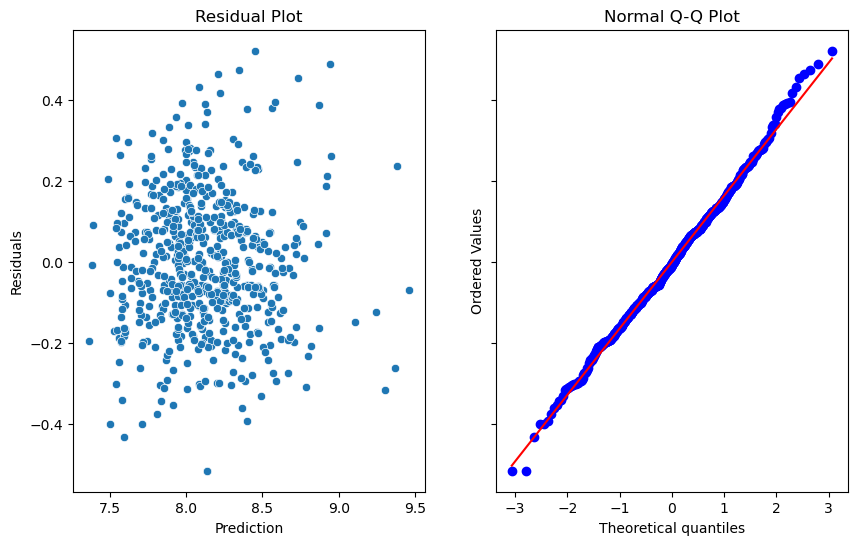

In [125]:
residual_analysis_plots(model)

# Currently after test 2 (model 2) our errors get larger with predictions
# Normality doesn't look the greatest either -2 - 2

# After model 3 - log transform we don't see clear pattern of violated equal variance
# Normality looks much better

In [126]:
# Examine Variance Inflation Factor (VIF)

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)

# Our concern are VIF > 5 
# Dummy variables > 5 are less concerning

# it's expected that when we introduce beds_bath_ratio our VIFs will jump 

const                        83.277385
sqft                          3.365155
beds                         20.260576
bath                          9.665212
beds_bath_ratio              11.722985
laundry_not-in-unit           1.393457
parking_(b) protected         7.756822
parking_(c) off-street        2.316665
parking_(d) no parking        8.439195
hood_district_central         1.420840
hood_district_marina          1.407959
hood_district_north beach     1.394883
hood_district_southwest       1.276615
hood_district_west            1.188312
dtype: float64

In [127]:
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df["cooks_d"].sort_values(ascending=False).head()

# No significant outliers

602    0.056244
863    0.039786
206    0.024471
466    0.023991
799    0.022859
Name: cooks_d, dtype: float64

In [128]:
X.loc[602]

const                           1.0
sqft                         2250.0
beds                            2.0
bath                            2.5
beds_bath_ratio                 0.8
laundry_not-in-unit             0.0
parking_(b) protected           0.0
parking_(c) off-street          0.0
parking_(d) no parking          0.0
hood_district_central           0.0
hood_district_marina            0.0
hood_district_north beach       0.0
hood_district_southwest         0.0
hood_district_west              0.0
Name: 602, dtype: float64

In [129]:
np.exp(y.loc[602])

12500.0

## Final Model Fit & Test Scoring

In [130]:
final_model = sm.OLS(y, X).fit()

final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     244.4
Date:                Tue, 05 Sep 2023   Prob (F-statistic):          5.40e-264
Time:                        21:35:37   Log-Likelihood:                 299.91
No. Observations:                 791   AIC:                            -571.8
Df Residuals:                     777   BIC:                            -506.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.5125      0.054    138.558      0.000       7.406       7.619
sqft                          0.0004   2.27e-05     16.042      0.000       0.000       0.000
beds                         -0.0517      0.025     -2.105      0.036      -0.100      -0.003
bath                          0.2368      0.033      7.237      0.000       0.173       0.301
beds_bath_ratio               0.1976      0.029      6.820      0.000       0.141       0.254
laundry_not-in-unit          -0.0839      0.014     -5.985      0.000      -0.111      -0.056
parking_(b) protected        -0.1564      0.033     -4.696      0.000      -0.222      -0.091
parking_(c) off-street       -0.1610      0.045     -3.610      0.000      -0.248      -0.073
parking_(d) no parking       -0.2293      0.035     -6.636      0.000      -0.297      -0.161
hood_district_central         0.0373      0.019      2.001      0.046       0.001       0.074
hood_district_marina          0.0875      0.021      4.195      0.000       0.047       0.128
hood_district_north beach    -0.0181      0.018     -1.033      0.302      -0.053       0.016
hood_district_southwest      -0.1649      0.023     -7.153      0.000      -0.210      -0.120
hood_district_west           -0.0726      0.030     -2.457      0.014      -0.131      -0.015
==============================================================================
Omnibus:                       18.184   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.344
Skew:                           0.020   Prob(JB):                     1.28e-08
Kurtosis:                       4.049   Cond. No.                     1.44e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [131]:
print(mae(np.exp(y_test), np.exp(final_model.predict(X_test)))) 
# print(f"Test MAE: {mae(y_test, model.predict(X_test))}") #468.13 if not transformed
print(f"Test R2: {r2(y_test, final_model.predict(X_test))}")

412.4986280201629
Test R2: 0.8551853336729451


Our final model MAE is $412. While this doesn't neccessarily indicate the most accurate model, there's a lot of factors concerning apartments that we cannot see. 